In [1]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import holidays
from sklearn.linear_model import RidgeCV

%matplotlib inline
# %config InlineBackend.figure_format = "retina"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

/var/folders/5r/_46vtm3167l75wv16plwtdq00000gq/T/ipykernel_22750/1336043820.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


## Load Training and Testing Data

In [26]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release",
         "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["post_month"]
del df["day"]
del df["month"]
df

,year,days_since_previous_release,release_post,date
id,,,,
50,2016,NaN,False,2016-02-15
123,2016,NaN,False,2016-02-15
173,2016,NaN,False,2016-02-15
156,2016,NaN,False,2016-02-15
133,2016,NaN,False,2016-02-15
...,...,...,...,...
378,2022,5.0,True,2022-01-25
379,2022,5.0,True,2022-09-08
380,2022,5.0,True,2022-12-07


In [27]:
df.query("release_post == True & days_since_previous_release.isnull()")

,year,days_since_previous_release,release_post,date
id,,,,


In [28]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [29]:
df = df[df["release_post"] == True].copy()

In [30]:
df = df[df["days_since_previous_release"] != 0].copy()

In [31]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})
del df["year"]

In [32]:
df = df.sort_values(by=["date"]).set_index("date")
daily = pandas.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(daily, method=None)
df["release_post"] = df["release_post"].fillna(False)

In [33]:
df = df.reset_index()
release_dates = list(df[df["release_post"] == True]["index"])
df["closest_release_date"] = df["index"].apply(lambda x : max([d for d in release_dates if d <= x]))
df["backfill"] = (df["index"] - df["closest_release_date"]).astype("timedelta64[D]")
df["days_since_previous_release"] = df["days_since_previous_release"].fillna(df["backfill"])
del df["backfill"]
del df["closest_release_date"]
df["future_release_date"] = df["index"].apply(lambda x : min([d for d in release_dates if d >= x]))
df["days_until_next_release"] = (df["future_release_date"] - df["index"]).astype("timedelta64[D]")
del df["future_release_date"]
df

,index,days_since_previous_release,release_post,days_until_next_release
0,2017-02-26,9.0,True,0.0
1,2017-02-27,1.0,False,19.0
2,2017-02-28,2.0,False,18.0
3,2017-03-01,3.0,False,17.0
4,2017-03-02,4.0,False,16.0
...,...,...,...,...
2134,2022-12-31,1.0,False,4.0
2135,2023-01-01,2.0,False,3.0
2136,2023-01-02,3.0,False,2.0
2137,2023-01-03,4.0,False,1.0


In [34]:
df["prob_of_release"] = (df["days_since_previous_release"] /
                         (df["days_since_previous_release"] + df["days_until_next_release"]))
del df["days_until_next_release"]
del df["release_post"]

## Features

In [35]:
def get_features(df):
    # in addition to days_since_previous_release
    
    df["month_holidays"] = df["index"].apply(
        lambda x : len([h for h in nj_holidays if h.month == x.month and h.year == x.year]))
    
    df["weekday"] = df["index"].apply(lambda x : x.strftime("%A"))
    df["month"] = df["index"].apply(lambda x : x.strftime("%b"))
    
    df = pandas.get_dummies(df, columns=["weekday"], prefix="WD")
    df = pandas.get_dummies(df, columns=["month"], prefix="M")
    
    return df

In [36]:
df = get_features(df)

## Model-Building and Evaluation

In [37]:
train_df = df[0:int(len(df) * 0.85)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1818 321


In [38]:
features = [c for c in df.columns if c not in ["index", "prob_of_release"]]
features

['days_since_previous_release',
 'month_holidays',
 'WD_Friday',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'M_Apr',
 'M_Aug',
 'M_Dec',
 'M_Feb',
 'M_Jan',
 'M_Jul',
 'M_Jun',
 'M_Mar',
 'M_May',
 'M_Nov',
 'M_Oct',
 'M_Sep']

In [16]:
reg = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
              scoring="neg_mean_absolute_percentage_error",
              cv=3)
reg.fit(train_df[features], train_df["prob_of_release"])

RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=3,
        scoring='neg_mean_absolute_percentage_error')

In [17]:
reg.best_score_

-0.4806367551109488

In [18]:
test_df["predicted"] = reg.predict(test_df[features])

In [19]:
mape(test_df["prob_of_release"], test_df["predicted"])

0.39564967930249567

<AxesSubplot: xlabel='predicted', ylabel='residuals'>

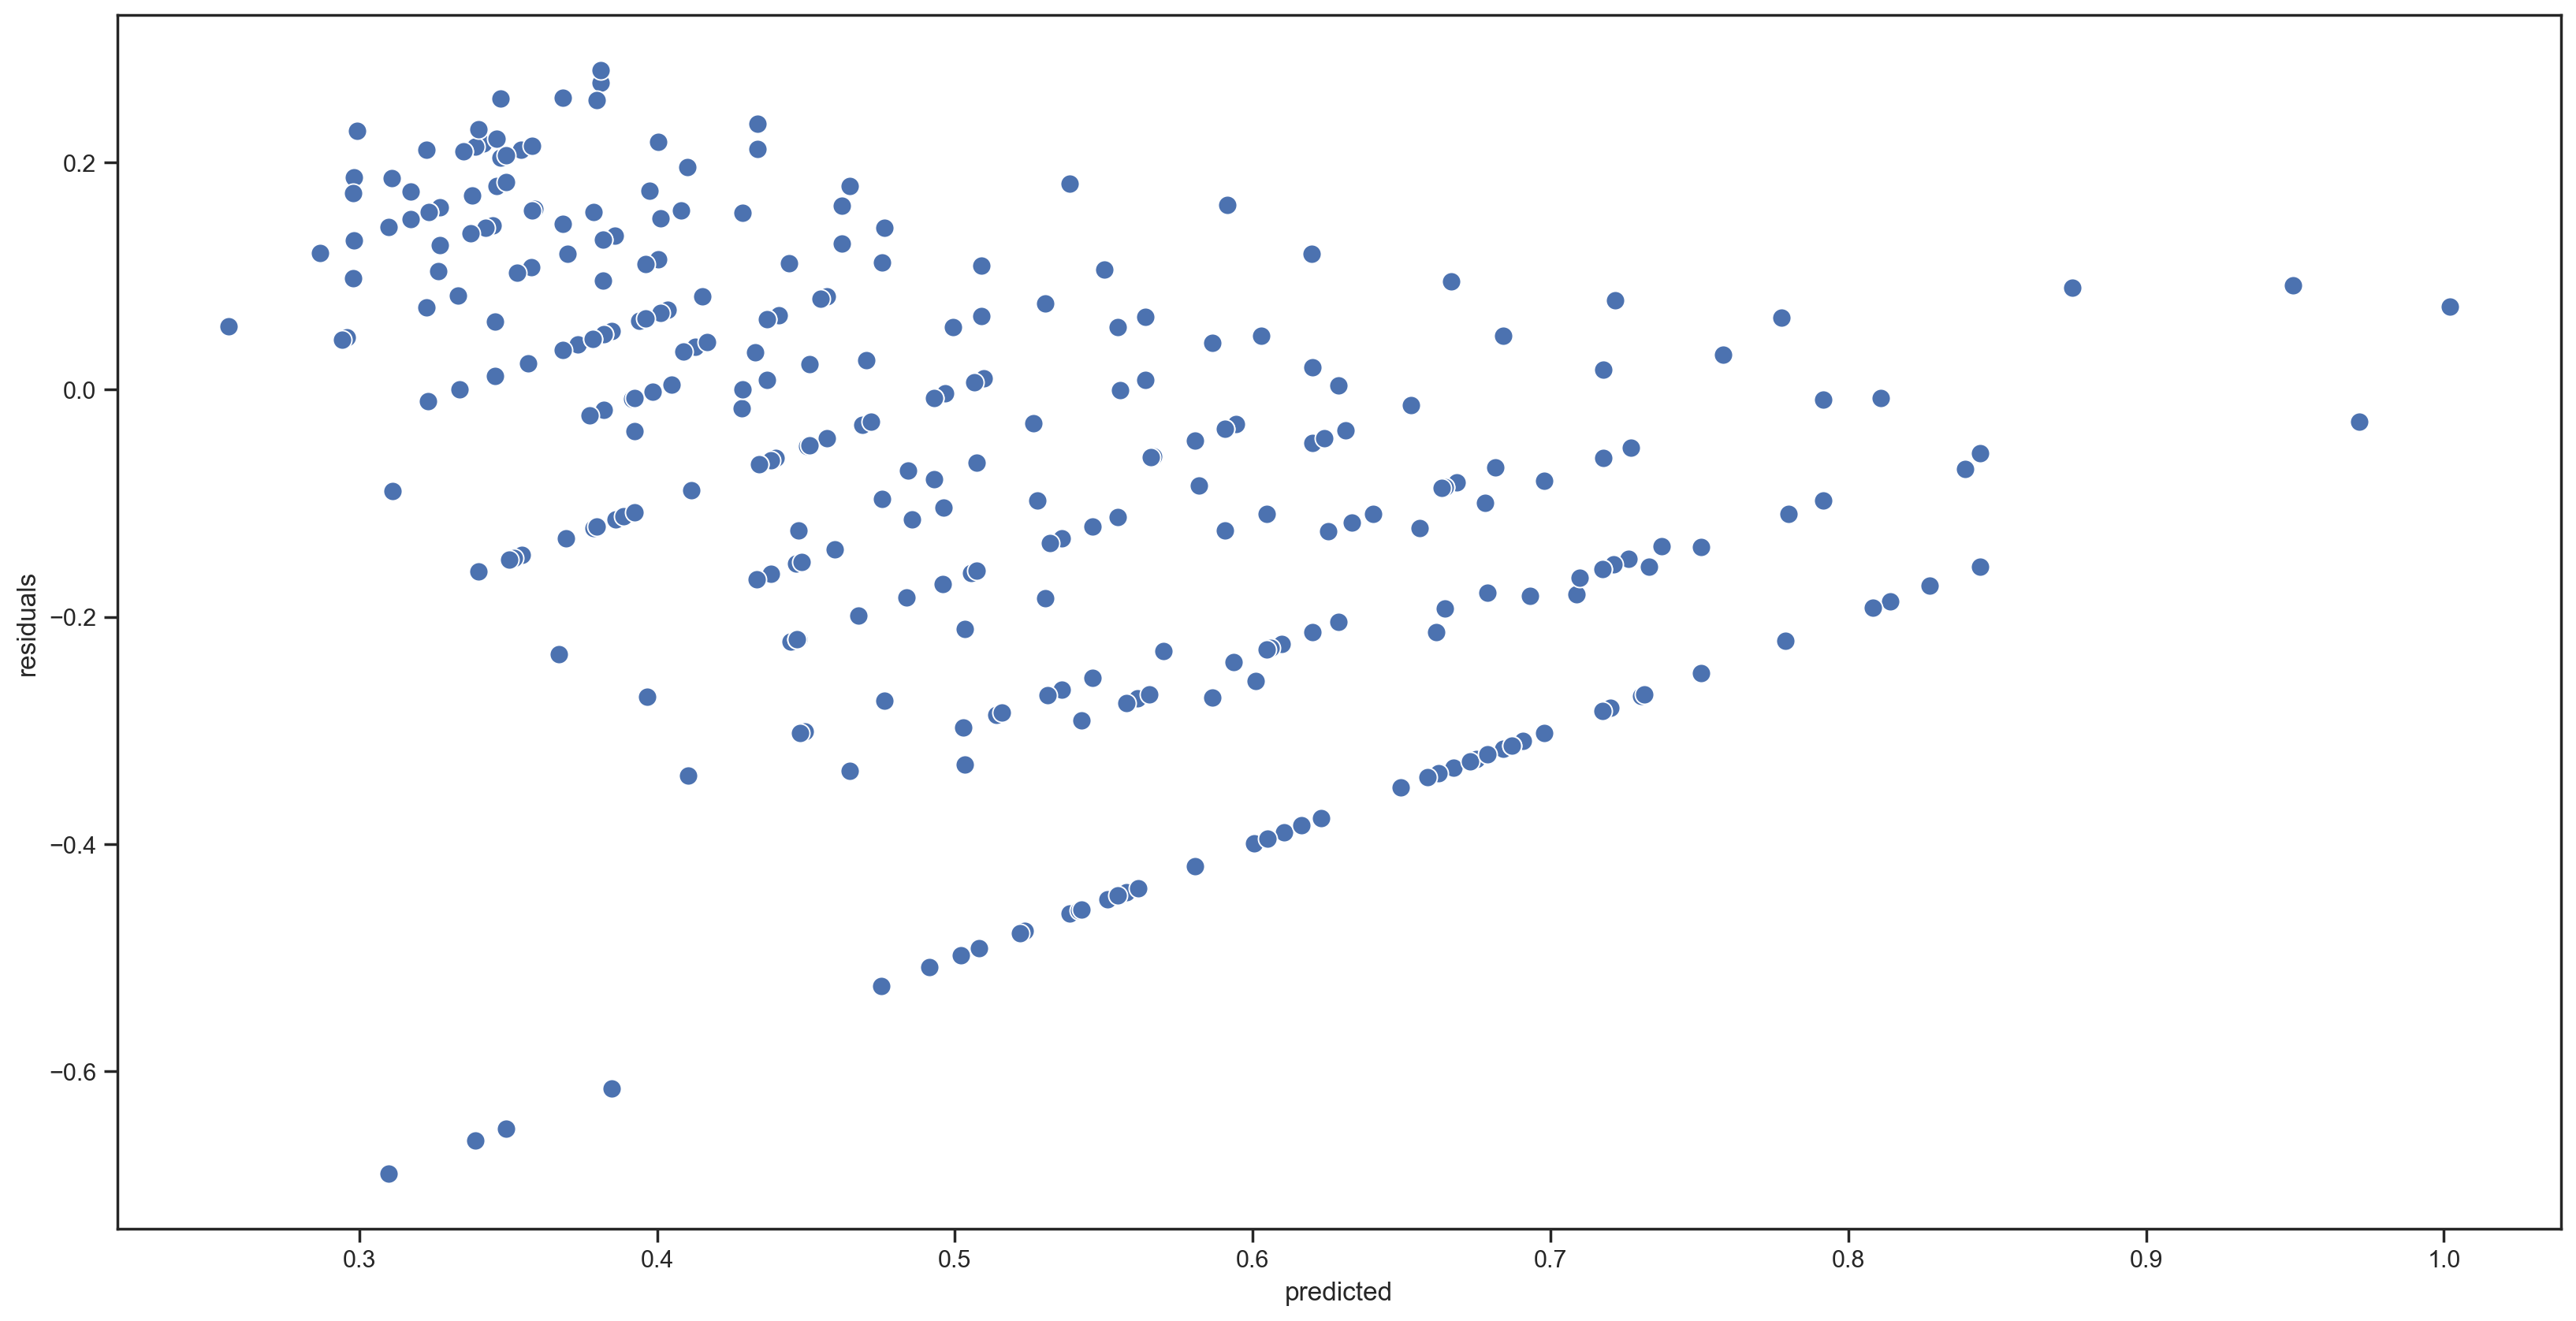

In [20]:
test_df["residuals"] = test_df["predicted"] - test_df["prob_of_release"]
sns.scatterplot(data=test_df, x="predicted", y="residuals", s=75)

In [74]:
sorted(zip(reg.feature_names_in_, reg.coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.05864844363822407),
 ('M_Sep', 0.04133919838447983),
 ('WD_Wednesday', 0.030206474376463465),
 ('M_Apr', 0.028263803375802088),
 ('WD_Thursday', 0.024307416379279703),
 ('M_Jul', 0.0223715579800063),
 ('M_Oct', 0.018540463405767295),
 ('WD_Tuesday', 0.014918690214285954),
 ('M_Nov', 0.01120212561002537),
 ('month_holidays', 0.010758024969876465),
 ('M_Jun', 0.010626130009714024),
 ('M_Jan', -0.0039077689647205325),
 ('M_May', -0.0052983076712762945),
 ('WD_Friday', -0.006035974922207596),
 ('M_Dec', -0.017598905382983594),
 ('WD_Saturday', -0.01783428206201582),
 ('M_Aug', -0.018954997943303922),
 ('WD_Sunday', -0.021467986850212235),
 ('WD_Monday', -0.024094337065596248),
 ('M_Feb', -0.037843276049651944),
 ('M_Mar', -0.04874002270759966)]

In [22]:
test_df[["prob_of_release", "predicted", "residuals"]].sort_values(by=["residuals"])

,prob_of_release,predicted,residuals
2112,1.000000,0.309724,-0.690276
1965,1.000000,0.338936,-0.661064
2091,1.000000,0.349283,-0.650717
1931,1.000000,0.384799,-0.615201
2028,1.000000,0.475201,-0.524799
...,...,...,...
2097,0.125000,0.379626,0.254626
1900,0.090909,0.347509,0.256600
1950,0.111111,0.368292,0.257181
1865,0.111111,0.381071,0.269960


## Predictions for the Next Week

In [61]:
last_release_date = test_df[test_df["prob_of_release"] == 1][-1:].iloc[0]["index"]
next_week = pandas.DataFrame([{"index" : t} for t in 
                              pandas.date_range(start=last_release_date, freq="1D", periods=8)])
next_week = next_week[1:].copy()
next_week["days_since_previous_release"] = range(1, len(next_week) + 1)
next_week = get_features(next_week)

for f in features:
    if f not in next_week.columns:
        next_week[f] = 0

In [62]:
next_week["predicted"] = reg.predict(next_week[features])

In [63]:
next_week[["index", "predicted"]]

,index,predicted
1,2023-01-05,0.364516
2,2023-01-06,0.392821
3,2023-01-07,0.439671
4,2023-01-08,0.494686
5,2023-01-09,0.550708
6,2023-01-10,0.648370
7,2023-01-11,0.722306
